In [109]:
def read_file_list(name):
    news = []
    with open(name, 'r', encoding = 'utf-8') as f:
        line = f.readline()[:-1]
        while not line.startswith('=!='):
            for i in range(5):
                line = f.readline()
            
            line = f.readline()[:-1]
            text = []
            while line !='=====' and not line.startswith('=!='):
                text.append(line)
                line = f.readline()[:-1]
            news.append(' '.join(text))
    return(news)

In [110]:
from natasha import Segmenter, MorphVocab, NewsEmbedding, NewsMorphTagger, NewsSyntaxParser, NewsNERTagger, PER, NamesExtractor, DatesExtractor, MoneyExtractor, AddrExtractor, Doc


segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)
dates_extractor = DatesExtractor(morph_vocab)
money_extractor = MoneyExtractor(morph_vocab)
addr_extractor = AddrExtractor(morph_vocab)

In [111]:
def text_names(s):
    doc = Doc(s)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.tag_ner(ner_tagger)

    for token in doc.tokens:
        token.lemmatize(morph_vocab)

    for span in doc.spans:
        span.normalize(morph_vocab)


    for span in doc.spans:
        if span.type == PER:
            span.extract_fact(names_extractor)
    return doc.spans

In [112]:
#source = list of people in a news article
#goal = dict of linked people
#[a1,a2,a3] -> {a1:{a2:1,a3:1}, a2:{a1:1,a3:1}, a3:{a1:1,a2:1}}

def add_person(source, goal):
    if len(source) == 1 and source[0] not in goal.keys():
        goal[source[0]] = {}
    else:
        for pers1 in source:
            others = source.copy()
            others.remove(pers1)
            for pers2 in others:
                if pers1 not in goal.keys():
                    goal[pers1] = {pers2:1}
                else:
                    if pers2 not in goal[pers1].keys():
                        goal[pers1][pers2] = 1
                    else:
                        goal[pers1][pers2] += 1
    return goal

In [113]:
def get_lastname(doc):
    if doc.fact and len(doc.fact.slots)!=1:
        return doc.fact.slots[1].value.lower()
    else:
        return doc.normal.lower()

In [114]:
def linked_people_graph1(l):
    lp = {}
    for text in l:
        names = []
        for ner_entry in text_names(text):
            if ner_entry.type == 'PER':
                if get_lastname(ner_entry) not in names:
                    names.append(get_lastname(ner_entry))
        lp = add_person(names, lp)
    return lp

In [115]:
l = read_file_list('mktula.txt')

In [117]:
graph = linked_people_graph1(l)

Для того чтобы учитывать меру "популярности" человека для анализа графа, сделаем словарь пар "фамилия + количество всех упоминаний человека с соседями"

In [118]:
freqs = {}
for k, v in graph.items():
    freqs[k] = sum(list(v.values()))

In [119]:
graph

{'лаврик': {'намин': 2,
  'мезенцев': 1,
  'башмет': 2,
  'березовский': 2,
  'луганский': 2,
  'ивановых': 2,
  'орбах': 2,
  'князев': 2,
  'бутман': 2,
  'тимошенко': 2,
  'белоусов': 2,
  'маслеев': 2,
  'шостакович': 2,
  'чайковский': 2,
  'арутюнян': 2,
  'квинтет': 1,
  'масхулия': 1,
  'дейва': 1},
 'намин': {'лаврик': 2,
  'мезенцев': 1,
  'башмет': 1,
  'маслеев': 1,
  'шостакович': 1,
  'чайковский': 1,
  'арутюнян': 1,
  'березовский': 1,
  'луганский': 1,
  'ивановых': 1,
  'орбах': 1,
  'князев': 1,
  'бутман': 1,
  'тимошенко': 1,
  'белоусов': 1,
  'квинтет': 1,
  'масхулия': 1,
  'дейва': 1},
 'мезенцев': {'лаврик': 1, 'намин': 1},
 'туовинен': {},
 'батиста': {},
 'глушко': {},
 'ярцев': {'ванцетти': 1,
  'дюмин': 1,
  'кузин': 1,
  'миляев': 2,
  'михеева': 1,
  'михеев': 1,
  'коротких': 1,
  'горький': 1,
  'судаково': 1,
  'казмерчук': 1,
  'сорокин': 1,
  'манаенкова': 1,
  'акселератор': 1},
 'ванцетти': {'ярцев': 1},
 'фролов': {'петров': 1, 'чекалин': 1, 'рум

<h2>Рисуем граф</h2>

In [120]:
import matplotlib.pyplot as plt
import networkx as nx
import math
import numpy as np

In [121]:
def create_graph(linked_people):
    G=nx.Graph()
    for n in linked_people.keys():
        for n2 in linked_people[n].keys():
            G.add_edge(n, n2)
    return G

In [122]:
def draw_graph(G, persons, freqs, colors = 'b', layout = 'spring'):
    if layout == 'kawai':
        pstn = nx.kamada_kawai_layout(G)
    elif layout == 'circle':
        pstn = nx.drawing.layout.circular_layout(G2)
    elif layout == 'random':
        pstn = nx.drawing.layout.random_layout(G2)
    else:
        pstn = nx.spring_layout(G)

    size = [freqs[n] for n in G.nodes]
    lw = [math.log(persons[e[0]][e[1]], 10)+1 for e in G.edges]

    nx.draw(G, pos = pstn, node_color = colors, edge_color = 'g', with_labels = True, node_size = size, width = lw);
    

In [123]:
G = create_graph(graph)

Сам граф:

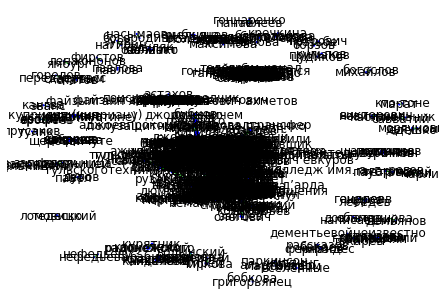

In [124]:
draw_graph(G, graph, freqs)

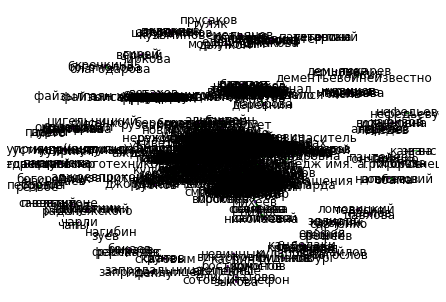

In [125]:
bb = nx.betweenness_centrality(G)
nx.set_node_attributes(G, bb, 'betweenness')

gclr=[bb[i] for i in G.nodes()]
draw_graph(G, graph, freqs, gclr)

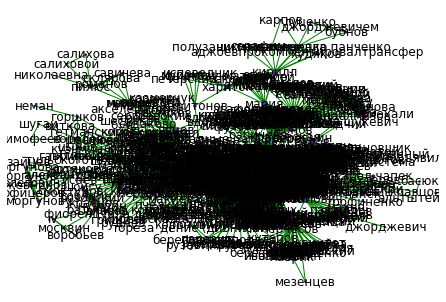

In [126]:
draw_graph(G, graph, freqs, gclr, 'kawai')

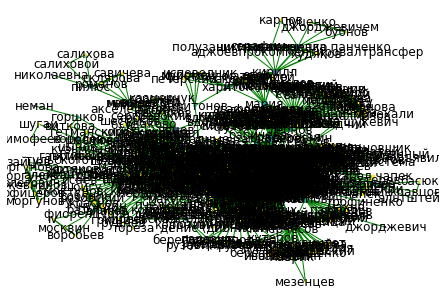

In [127]:
сс = nx.clustering(G)
gclr=[сс[i] for i in G.nodes()]
draw_graph(G, graph, freqs, gclr, 'kawai')

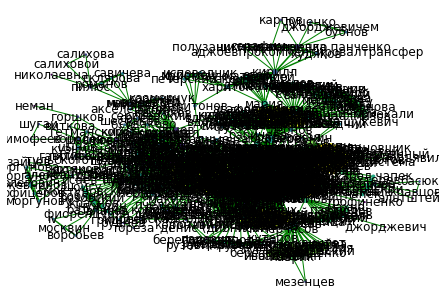

In [128]:
сс = nx.clustering(G)
gclr=[сс[i]*math.log(len(G[i].keys())) for i in G.nodes()]
draw_graph(G, graph, freqs, gclr, 'kawai')